1. MLP
- Load and preprocess the dataset
- Train and test MLP model on dataset while tunning parameters to develop multiple candidates
- Evaluate models using appropriate metrics
- Select most promising model
- Predict response variable for validation inputs by using most promising mode

In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [3]:
# Reading in the training/test data

file_path = '../data/project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '../data/project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  ca

In [4]:
# Reading in the validation data

file_path = '../data/project_validation_inputs.csv'

try:
    df_test = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df_test.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded '../data/project_validation_inputs.csv'. First 5 rows:
        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-ga

In [5]:
# Checking shape of dataframes
display(df_test.shape)
display(df.shape)

(6514, 15)

(26049, 16)

In [6]:
# Missing values represented as '?' in this data
# Count "?" in each column
question_counts = (df == "?").sum()
print(question_counts)

0        0
1        0
2     1447
3        0
4        0
5        0
6        0
7     1454
8        0
9        0
10       0
11       0
12       0
13       0
14     458
15       0
dtype: int64


In [7]:
# process and standardize the test/train data function
def preprocess_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', 'Missing', inplace=True)  # Letting missing values be their own class as they're only in categorical columns

    # Binarize the target variable
    df['class'] = df['class'].apply(lambda x: 1 if x == '>50K' else 0)

    # Keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    # Encode categorical features
    df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], dtype = int)

    # Ensure all data types are numeric after encoding
    df = df.apply(pd.to_numeric, errors='coerce')

    # Separate features and target
    X = df.drop(columns=['class'], axis=1)
    y = df[['original_index','class']]

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # Display preprocessed data
    merged_df = pd.concat([X, y['class']], axis=1)
    display(merged_df.head())

    # Return encoding to be using for validation data to maintain consistency
    return X, y

In [8]:
# Preprocess training/test data
X, y = preprocess_data(df)

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male,class
0,1,-0.408756,0.080051,1.133702,-0.145715,-0.217998,0.779460,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,2,-0.188857,-0.981653,0.357049,-0.145715,4.457168,0.779460,0,0,0,...,0,0,0,0,1,0,0,0,1,1
2,3,1.423734,0.126197,-1.972910,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,-1.288351,-0.090935,0.357049,-0.145715,-0.217998,0.455072,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,5,-0.848554,0.856334,-0.031277,-0.145715,-0.217998,-0.031510,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [9]:
# Process and standardize validation data function
# Decided to create another function and remove any lines related to target column so that it worked for the validation dataset

def preprocess_validation_data(df):

    # Drop the first column (seems like just a random index) and first row (column names)
    df = df.iloc[1:, 1:]
    
    # correct column names
    new_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
    df.columns = new_column_names

    # Handle missing values
    df.replace('?', 'Missing', inplace=True) # Letting missing values be their own class as they're only in categorical columns

    # keep track of rows indexes to connect X and y
    df = df.reset_index(names=['original_index'])

    # Encode categorical features
    df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], dtype = int)

    # Ensure all data is numeric after encoding
    df = df.apply(pd.to_numeric, errors='coerce')

    # Assign features to X
    X = df

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # display preprocessed data
    display(X.head())

    return X

In [10]:
# preprocess validation data
X_df_test = preprocess_validation_data(df_test)

,original_index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Missing,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,sex_Female,sex_Male
0,1,-0.851191,-0.277853,-0.031693,-0.147225,-0.211274,-0.212164,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,2,0.469374,-1.304090,-0.421896,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,-0.704461,-0.036955,1.138915,-0.147225,-0.211274,1.157652,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,-0.631097,0.001731,1.138915,-0.147225,-0.211274,-0.051009,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,5,-0.704461,-0.004766,-0.031693,0.128973,-0.211274,0.754765,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [17]:
# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [ ]:
# don't think we need this since we standardized in the preprocessing function
# normalizing the features
# X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

In [18]:
# assigning feature columns to variable for easy recall and avoid dropping 'original_index'
# also validation dataset lacked 3 columns after encoded so excluding those as well to avoid shape mismatch issues

feature_cols = [col for col in X_train.columns if col not in ['original_index', 'workclass_Never-worked', 'native-country_Holand-Netherlands', 'native-country_Outlying-US(Guam-USVI-etc)']]
print(feature_cols)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Missing', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation

In [19]:
# converting to PyTorch tensors 
X_train = torch.from_numpy(X_train.loc[:,feature_cols].values).float()
y_train = torch.from_numpy(y_train.loc[:,'class'].values)

In [20]:
# creating a TensorDataset for training data
train_ds = TensorDataset(X_train, y_train)

In [21]:
# creating a DataLoader with batch size of 2
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [22]:
# defining the model architecture
class Model(nn.Module):
    
    # constructor with 1 hidden layer
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    # forward pass using activation function Sigmoid and Softmax
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [23]:
# creating the model
input_size = X_train.shape[1]
# setting hidden layer size and output layer size
hidden_size = 16
output_size = 3

# instantiate the model
model = Model(input_size, hidden_size, output_size)

In [24]:
# defining the loss function
loss_fn = nn.CrossEntropyLoss()

In [25]:
# defining the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# training the model and recording loss and accuracy
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

# training loop
for epoch in range(num_epochs):

    # iterating through batches
    for x_batch, y_batch in train_dl:
        # 1. generate predictions
        pred = model(x_batch)
        # 2. calculate the loss
        loss = loss_fn(pred, y_batch.long())
        # 3. compute gradients
        loss.backward()
        # 4. update model parameters using gradients
        optimizer.step()
        # 5. reset the gradients to zero
        optimizer.zero_grad()

        # recording loss and accuracy
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    # normalizing loss and accuracy
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

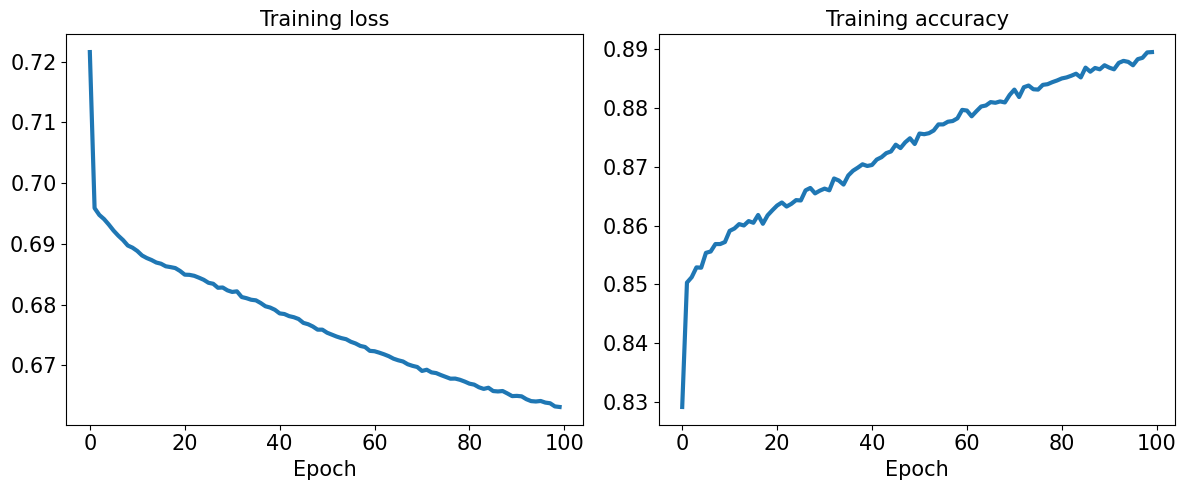

In [27]:
# plotting the loss and accuracy
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# second subplot
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

In [29]:
# again idk if we need this 
# normalizing the test set
# X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
# converting to PyTorch tensor
X_test = torch.from_numpy(X_test.loc[:,feature_cols].values).float()

In [30]:
# converting y_test to a tensor
y_test = torch.from_numpy(y_test.loc[:,'class'].values)

In [31]:
# making predictions on the test set
pred_test = model(X_test)

In [32]:
# calculating the accuracy on the test set
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8517


In [33]:
# saving the model 
path = 'income_classifier.pt'
torch.save(model, path)

In [34]:
# loading the model 
model_new = torch.load(path, weights_only=False)
# evaluating the loaded model
model_new.eval()

Model(
  (layer1): Linear(in_features=105, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [35]:
# making predictions on the test set using the loaded model
pred_test = model_new(X_test)

In [36]:
# calculating the accuracy  on the test set using the loaded model
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8517


In [37]:
# saving only the model state_dict 
# state_dict contains the model parameters
path = 'income_classifier_state.pt'
torch.save(model.state_dict(), path)

In [38]:
# loading the model state_dict
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>